In [1]:
import tensorflow as tf
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from vindy import SindyNetwork
from vindy.layers import SindyLayer, VindyLayer
from vindy.distributions import Gaussian, Laplace
from vindy.libraries import PolynomialLibrary
from vindy.callbacks import (
    SaveCoefficientsCallback,
)
from vindy.utils import add_lognormal_noise
from ekf_vindy.plotting.plotter import plot_trajectory
from scipy.integrate import odeint


2025-09-15 18:06:22.738864: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-15 18:06:22.757056: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-15 18:06:22.906168: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-15 18:06:23.040935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757952383.180791    4507 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757952383.22

LaTeX is installed. Using LaTeX for rendering.


## Selkov system

We will use a Selkov model, which will then be subject to bifurcations. The system generating the data is

$$
\begin{aligned}
\dot{x}_1 &= \rho + \zeta_1 x_1-\theta_1 x_1 x_2^2,\\
\dot{x}_2 &= \zeta_2 x_1 + \psi x_2 + \theta_2 x_1 x_2^2.
\end{aligned}
$$

When the flag $\texttt{train}$ is set to $\texttt{False}$ we have time-varying parameters (e.g., bifurcations).

In [2]:
def selkov(y, t, params, t_offset = 0, t_bifurcation = 0, train = True):
    # Selkov model
    u1, u2 = y
    
    if train:
        rho = params['rho']
    if not train:
        if t < t_bifurcation:
            rho = params['rho']
        elif t > t_bifurcation + t_offset:
            rho = params['rho_bifurcation']
        else:
            rho = params['rho'] + (params['rho_bifurcation'] - params['rho']) * (t - t_bifurcation) / t_offset
   
    du1 = rho - params['sigma'] * u1 - params['b122_1'] * u1 * u2**2
    du2 = params['sigma'] * u1 - params['k2'] * u2 + params['b122_2'] * u1 * u2**2

    return [du1, du2]

Some silly script parameters

In [3]:
sindy_type = "vindy"  # "sindy" or "vindy", if you either want a deterministic or probabilistic model for the dynamics, respectively.
model_name = "selkov"
seed = 29 # random seed
measurement_noise_factor = 0.01 # measurement noise factor
n_train = 30 # number of training trajectories
n_test = 4 # number of test trajectories

To save weights and not have to retrain...

In [4]:
def generate_directories(model_name, sindy_type, scenario_info, outdir):
    # Base output directory
    outdir = os.path.join(outdir, model_name, sindy_type)
    
    # Subdirectories
    figdir = os.path.join(outdir, "figures", scenario_info)
    log_dir = os.path.join(outdir, model_name, "log", scenario_info)
    weights_dir = os.path.join(outdir, "weights", scenario_info)
    
    # Create directories if they don't exist
    for dir_path in [outdir, figdir, log_dir, weights_dir]:
        os.makedirs(dir_path, exist_ok=True)

    return outdir, figdir, log_dir, weights_dir

In [5]:
scenario_info = f"{sindy_type}_nbd_me_seed_{seed}_noise_{measurement_noise_factor}"
_, _, _, weights_dir = generate_directories(model_name, sindy_type, scenario_info, "results")

In [6]:
params = {
    "rho": 0.92,
    "rho_bifurcation": 0.7,  # for example, after bifurcation
    "sigma": 0.1,
    "k2": 1.0,
    "b122_1": 1.0,
    "b122_2": 1.0,
}

In [7]:
# generate data from Selkov model and compute derivatives (from data)
initial_conditions = np.random.normal(0.2, 1, (n_train + n_test, 2))
dt = 0.1
time_instances = np.arange(0, 100, dt)


x_train = np.array([
        odeint(selkov, y0, time_instances, args=(params,))
        for y0 in initial_conditions[:n_train]
    ])

x_train = np.array([add_lognormal_noise(x, measurement_noise_factor)[0] for x in x_train])

dxdt_train = np.array([
                    np.gradient(x, dt, axis=0)
                    for x in x_train
                ])

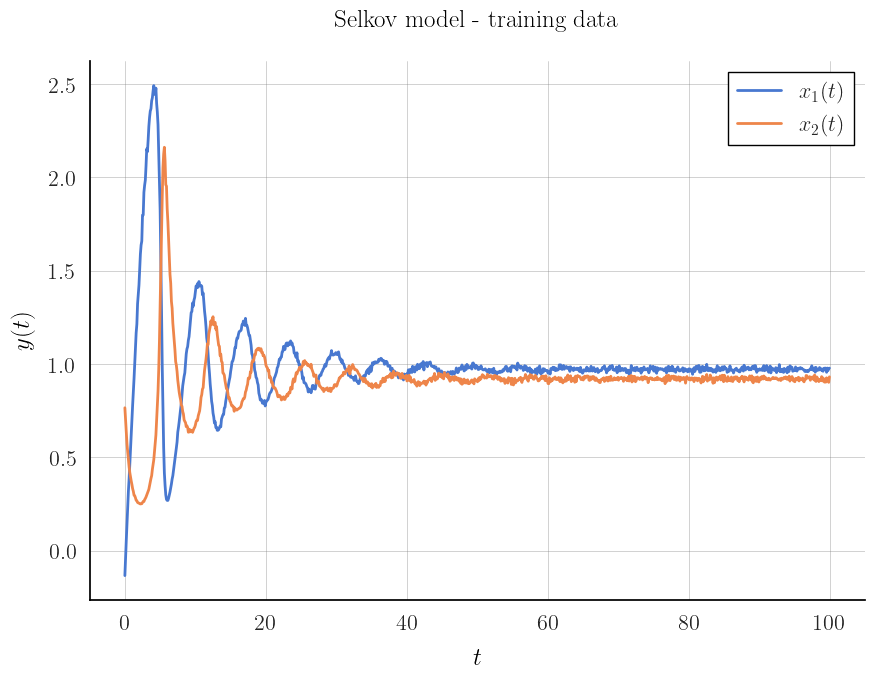

In [8]:
fig, ax = plot_trajectory(x_train[0, :, :], time_instances, x_tick_skip=20, title="Selkov model - training data")
plt.show()

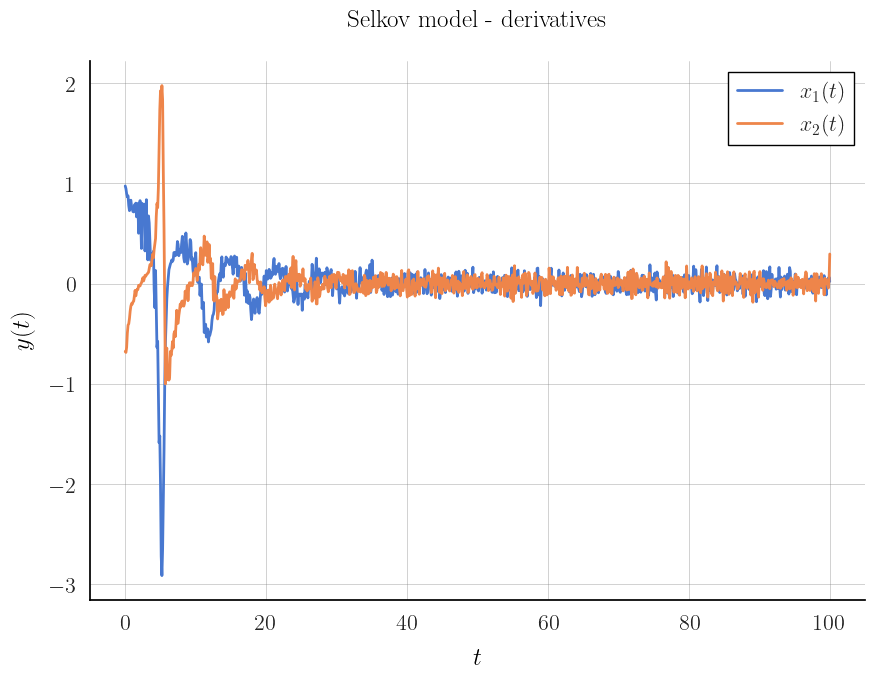

In [9]:
# plot derivatives
fig, ax = plot_trajectory(dxdt_train[0, :, :], time_instances, x_tick_skip=20, title="Selkov model - derivatives")
plt.show()

Now we fit the model with VINDy using Laplace priors

In [17]:

# model parameters
libraries = [
    PolynomialLibrary(2, include_bias=True),
]
dt = 0.1

# create sindy layer
layer_params = dict(
    state_dim=x_train.shape[1], 
    param_dim=0,
    feature_libraries=libraries,
    second_order=False,
    mask=None,
    kernel_regularizer=tf.keras.regularizers.L1L2(l1=0, l2=0),
)
if sindy_type == "vindy":
    sindy_layer = VindyLayer(
        beta=1e-3,
        priors=Laplace(0.0, 1.0),
        **layer_params,
    )
elif sindy_type == "sindy":
    sindy_layer = SindyLayer(
        **layer_params,
    )
else:
    raise ValueError(f"Unknown SINDy type: {sindy_type}")

# create autoencoder sindy model
model = SindyNetwork(
    sindy_layer=sindy_layer,
    x=x_train,
    l_dz=1e0,
    dt=dt,
    second_order=False,
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="huber")

KeyboardInterrupt: 

In [60]:
weights_path = os.path.join(weights_dir, ".weights.h5")

model.build([
    (None, x_train.shape[1]),    # shape for x_train
    (None, dxdt_train.shape[1])  # shape for dxdt_train
])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(weights_path),
        save_weights_only=True,
        save_best_only=True,
        monitor="loss",
        verbose=0,
    ),
    SaveCoefficientsCallback()
]

trainhist = model.fit(
    x=[x_train, dxdt_train],
    callbacks=callbacks,
    y=None,
    epochs=500,
    batch_size=256,
    verbose=1,
)
# Save weights manually
model.save_weights(weights_path)

# apply pdf threshold
threshold = 0.5

NameError: name 'model' is not defined